In [1]:
import torch

In [2]:
disable_cuda = False

# CUDA setup

In [3]:
if not disable_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CUDA


In [4]:
from heron.models.torchbased import HeronCUDA, HeronCUDAIMR
from elk.waveform import Timeseries, FrequencySeries
import numpy as np

In [5]:
generator = HeronCUDAIMR(device=device)

In [6]:
from heron.utils import Complex
from heron.likelihood import InnerProduct, CUDALikelihood

In [7]:
import matplotlib.pyplot as plt

In [8]:
window = torch.blackman_window(164, device=device)

## PSD setup

In [9]:
import lalsimulation
import lal

In [10]:
lal_psds = {key: value for key, value in lalsimulation.__dict__.items() if key[-3:] == "Ptr"}

In [11]:
delta_f = 40
length = 83

In [12]:
lalseries = lal.CreateREAL8FrequencySeries(
            '', lal.LIGOTimeGPS(0), 0, delta_f, lal.DimensionlessUnit, length)

In [13]:
lalsimulation.SimNoisePSD(lalseries, 0, lal_psds["SimNoisePSDaLIGOZeroDetHighPowerPtr"])

0

In [14]:
aligo_psd = lalseries.data.data

In [15]:
mi=0.8
ls_all = []
#for mi in np.linspace(0.25, 1.0, 100):
window = torch.blackman_window(32, device=device)
signal = generator.frequency_domain_waveform({'mass ratio': mi, 'distance': 1e6}, 
                                             window=window,
                                            times=torch.linspace(-0.02, 0.005, 32))

/home/daniel/repositories/heron/heron/models/torchbased.py:579: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  strain_f = torch.view_as_complex((window*mean.double()).rfft(1))


In [16]:
signal_t = generator.time_domain_waveform({'mass ratio': 0.8}, 
                                            times=torch.linspace(-0.02, 0.005, 64))

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


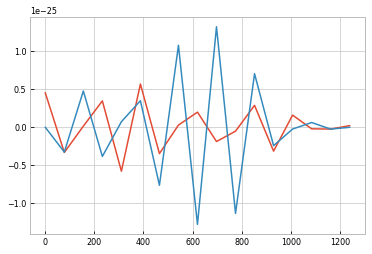

In [17]:
plt.plot(signal['plus'].frequencies, signal['plus'].data.real.cpu())
plt.plot(signal['plus'].frequencies, signal['plus'].data.imag.cpu())

#plt.xlim([0,500])

/home/daniel/.virtualenvs/gaston/sandbox/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  """Entry point for launching an IPython kernel.


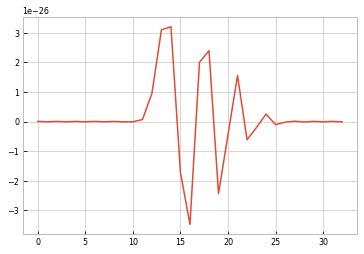

In [18]:
plt.plot(torch.irfft(torch.view_as_real(signal['plus'].data), 1).cpu())

In [19]:
psd = torch.tensor(aligo_psd, device=device, dtype=torch.cdouble)

In [20]:
window = torch.blackman_window(164, device=device)

signal = generator.frequency_domain_waveform({'mass ratio': 0.5, 'distance': 1e9}, 
                                             window=window,
                                            times=torch.linspace(-0.02, 0.005, 164))

detection = signal['plus'] 
detection.data += torch.sqrt(psd)
l = CUDALikelihood(generator, detection, window, start=-0.02, psd=psd.clone(), device=device)
l.duration = 0.0125

In [21]:
ls = np.array([(l({"mass ratio": m, "distance": 1e9}, model_var=True)).cpu().numpy() 
      for m in np.linspace(0.25,.9, 100)])

ls2 = np.array([(l({"mass ratio": m, "distance": 1e9}, model_var=False)).cpu().numpy() 
      for m in np.linspace(0.25,.9, 100)])

IndexError: too many indices for tensor of dimension 1

In [ ]:
f, ax = plt.subplots(1,1, dpi=300)

ax.plot(np.linspace(0.25, 0.9, 100), ls, label='With model uc')
#ax.plot(np.linspace(0.25, 0.5, 100), ls*6e7, label='With model uc')

#ax.plot(np.linspace(0.25, 0.9, 100), ls2, label='Without model uc')

ax.legend()

In [ ]:
torch.prod((l._call_model({"mass ratio": m, "distance": 1e5})['plus'].variance.modulus / l.psd.modulus)[1:-1])

In [ ]:
ip=InnerProduct(psd=l.psd.clone(), duration=0.025)
hh=[]
dh=[]
dd = []
ms = np.linspace(0.2, 0.9, 100)

for m in ms:
    #signal = l._call_model(p={'mass ratio': m, 'distance' :0.1})
    signal = generator.frequency_domain_waveform({'mass ratio': m, 'distance' :0.1}, 
                                             window=l.window,
                                            times=torch.linspace(-0.02, 0.005, 164))
    hh.append(ip(signal['plus'].data, signal['plus'].data))
    dh.append(ip(signal['plus'].data, detection.data))
    dd.append(ip(detection.data, detection.data))

hh=np.array(hh)
dh=np.array(dh)
#plt.plot(ms, hh, label='hh')
#plt.plot(ms, dh, label='dh')
plt.plot(ms, 2*dh-hh-dd)
plt.grid()
plt.legend()

In [ ]:
a = signal['plus'].data * 1e21

In [ ]:
b = signal['plus'].data * 1e21

In [ ]:
M = torch.diag(1./psd.modulus) * 1e-42

In [ ]:
torch.sum(((a.conjugate * b) / (psd* 1e42)).real[1:-1])

In [ ]:
c = Complex(0)#.#torch.zeros((len(a.real), len(b.real)))
for i in range(1,len(a.real)-1):
    for j in range(1, len(b.real)-1):
        #a.conjugate * M * b
        c += a[i].conjugate *M[i,j] * b[j]
        

In [ ]:
c